In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

# Momentum Trading Strategy

In [9]:
# Getting the Nasdaq 100 ticker symbols from Wikipedia
nas_df = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
tickers = nas_df.Ticker.to_list()

In [14]:
# Download the Nasdaq 100 Adjusted Close price data with yfinance
df = yf.download(tickers, start="2010-01-01")["Adj Close"]

[*********************100%***********************]  101 of 101 completed


In [16]:
df = df.dropna(axis=1)

In [17]:
# Calculate monthly return
mtl = (df.pct_change() + 1)[1:].resample('M').prod()

In [20]:
def get_rolling_ret(df, n):
    return df.rolling(n).apply(np.prod)

In [22]:
ret_12 = get_rolling_ret(mtl, 12)
ret_6 = get_rolling_ret(mtl, 6)
ret_3 = get_rolling_ret(mtl, 3)

In [23]:
def get_top(date):
    top_50 = ret_12.loc[date].nlargest(50).index
    top_30 = ret_6.loc[date, top_50].nlargest(30).index
    return ret_3.loc[date, top_30].nlargest(10).index

In [25]:
def pf_performance(date):
    portfolio = mtl.loc[date:, get_top(date)][1:2]
    return portfolio.mean(axis=1).values[0]

In [27]:
returns = []

for date in mtl.index[:-1]:
    returns.append(pf_performance(date))

<AxesSubplot: xlabel='Date'>

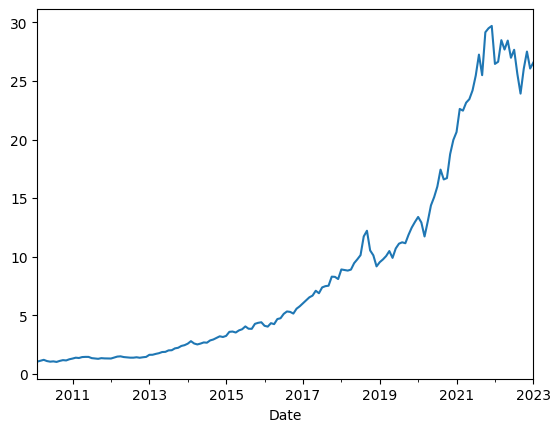

In [32]:
pd.Series(returns,index=mtl.index[1:]).cumprod().plot()